In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [23]:
# Load the training dataset
train_data = pd.read_csv("train_data.csv")
# Load the testing dataset
test_data = pd.read_csv("test_data.csv")
# Load the RUL forecast length for the testing set
rul_forecast_length = pd.read_csv("RUL_forecast_length.csv")

In [25]:
# Display basic information about the dataset
print(test_data.info())
print(rul_forecast_length.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6412 entries, 0 to 6411
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Engine id              6412 non-null   int64  
 1   Cycle number           6412 non-null   int64  
 2   Operation Condition 1  6412 non-null   float64
 3   Operation Condition 2  6412 non-null   float64
 4   Operation Condition 3  6412 non-null   float64
 5   T2                     6412 non-null   float64
 6   T24                    6412 non-null   float64
 7   T30                    6412 non-null   float64
 8   T50                    6412 non-null   float64
 9   P2                     6412 non-null   float64
 10  P15                    6412 non-null   float64
 11  P30                    6412 non-null   float64
 12  Nf                     6412 non-null   float64
 13  Nc                     6412 non-null   float64
 14  epr                    6412 non-null   float64
 15  Ps30

In [27]:
# Display descriptive statistics
print(test_data.describe())
print(rul_forecast_length.describe())

         Engine id  Cycle number  Operation Condition 1  \
count  6412.000000   6412.000000            6412.000000   
mean     75.870555     68.748596              -0.000046   
std      14.383795     44.244198               0.002183   
min      51.000000      1.000000              -0.008700   
25%      64.000000     33.000000              -0.001500   
50%      76.000000     65.000000               0.000000   
75%      88.000000     98.000000               0.001400   
max     100.000000    217.000000               0.007100   

       Operation Condition 2  Operation Condition 3            T2  \
count           6.412000e+03                 6412.0  6.412000e+03   
mean           -6.394261e-07                  100.0  5.186700e+02   
std             2.931888e-04                    0.0  4.525089e-11   
min            -6.000000e-04                  100.0  5.186700e+02   
25%            -3.000000e-04                  100.0  5.186700e+02   
50%             0.000000e+00                  100.0  5

In [28]:
# Check for missing values
print(test_data.isnull().sum())
print(rul_forecast_length.isnull().sum())

Engine id                0
Cycle number             0
Operation Condition 1    0
Operation Condition 2    0
Operation Condition 3    0
T2                       0
T24                      0
T30                      0
T50                      0
P2                       0
P15                      0
P30                      0
Nf                       0
Nc                       0
epr                      0
Ps30                     0
phi                      0
NRf                      0
NRc                      0
BPR                      0
farB                     0
htBleed                  0
Nf_dmd                   0
PCNfR_dmd                0
W31                      0
W32                      0
dtype: int64
Forecast Length    0
Engine id          0
dtype: int64


In [29]:
# Select relevant columns (excluding unit number and cycle number)
cols_to_keep = train_data.columns[2:]
train_data = train_data[cols_to_keep]

In [30]:
# Normalize the data
scaler = MinMaxScaler()
common_cols = train_data.columns.intersection(cols_to_keep[1:])  # Exclude the first column (time) for common columns
train_data_normalized = scaler.fit_transform(train_data[common_cols])

In [31]:
# Define the sequence length (number of cycles to look back for each data point)
sequence_length = 50

In [32]:
# Prepare training data
X_train, y_train = [], []
for i in range(len(train_data_normalized) - sequence_length + 1):
    seq = train_data_normalized[i:i + sequence_length]
    label = train_data_normalized[i + sequence_length - 1, 0]  # Assuming RUL is in the first column
    X_train.append(seq)
    y_train.append(label)

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape data for LSTM input (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], sequence_length, X_train.shape[2]))

In [33]:
# Function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Create and train the LSTM model
input_shape = (sequence_length, X_train.shape[2])
lstm_model = create_lstm_model(input_shape)
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
309/309 [==============================] - 14s 33ms/step - loss: 0.0362
Epoch 2/10
309/309 [==============================] - 8s 27ms/step - loss: 4.2585e-04
Epoch 3/10
309/309 [==============================] - 10s 32ms/step - loss: 7.4023e-05
Epoch 4/10
309/309 [==============================] - 9s 28ms/step - loss: 3.3870e-05
Epoch 5/10
309/309 [==============================] - 10s 32ms/step - loss: 2.2170e-05
Epoch 6/10
309/309 [==============================] - 8s 26ms/step - loss: 1.7003e-05
Epoch 7/10
309/309 [==============================] - 9s 29ms/step - loss: 1.3676e-05
Epoch 8/10
309/309 [==============================] - 8s 27ms/step - loss: 1.2328e-05
Epoch 9/10
309/309 [==============================] - 9s 29ms/step - loss: 1.2645e-05
Epoch 10/10
309/309 [==============================] - 9s 28ms/step - loss: 1.4982e-05


In [34]:
# Select relevant columns and exclude unit number
test_data = test_data[common_cols]

# Ensure that the testing dataset has the same columns as the training dataset
test_data_normalized = scaler.transform(test_data)

In [35]:
# Prepare test data
X_test, y_test = [], []
for i in range(len(test_data_normalized) - sequence_length + 1):
    seq = test_data_normalized[i:i + sequence_length]
    label_index = min(i + sequence_length - 1, len(rul_forecast_length) - 1)
    label = rul_forecast_length.iloc[label_index, 0]  # Forecast length
    X_test.append(seq)
    y_test.append(label)

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape test data for LSTM input
X_test = np.reshape(X_test, (X_test.shape[0], sequence_length, X_test.shape[2]))

In [36]:
# Evaluate the model on the test data
test_loss = lstm_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

199/199 [==============================] - 4s 13ms/step - loss: 6319.3345
Test Loss: 6319.33447265625


199/199 [==============================] - 3s 13ms/step


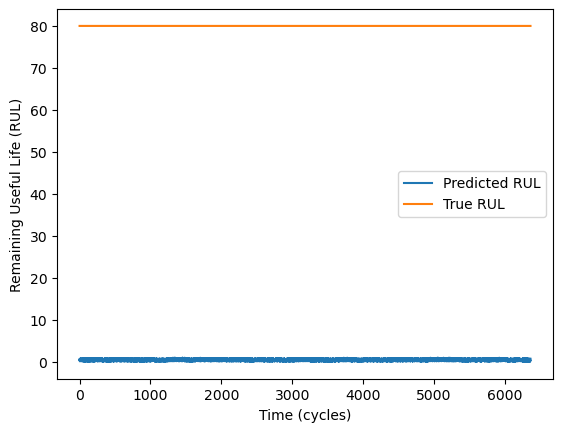

In [37]:
# Make predictions on the test data
predictions = lstm_model.predict(X_test)

# Plot the results
plt.plot(predictions, label='Predicted RUL')
plt.plot(y_test, label='True RUL')
plt.legend()
plt.xlabel('Time (cycles)')
plt.ylabel('Remaining Useful Life (RUL)')
plt.show()

In [38]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Engine ID': test_data.index[sequence_length - 1:],
    'True RUL': y_test,
    'Predicted RUL': predictions.flatten()
})

# Display the results for each engine
for engine_id, engine_group in results_df.groupby('Engine ID'):
    print(f"\nResults for Engine {engine_id}:\n")
    print(engine_group)


Results for Engine 49:

   Engine ID  True RUL  Predicted RUL
0         49        80         0.5902

Results for Engine 50:

   Engine ID  True RUL  Predicted RUL
1         50        80        0.34207

Results for Engine 51:

   Engine ID  True RUL  Predicted RUL
2         51        80       0.672137

Results for Engine 52:

   Engine ID  True RUL  Predicted RUL
3         52        80       0.505637

Results for Engine 53:

   Engine ID  True RUL  Predicted RUL
4         53        80       0.173071

Results for Engine 54:

   Engine ID  True RUL  Predicted RUL
5         54        80       0.505436

Results for Engine 55:

   Engine ID  True RUL  Predicted RUL
6         55        80       0.340065

Results for Engine 56:

   Engine ID  True RUL  Predicted RUL
7         56        80       0.175085

Results for Engine 57:

   Engine ID  True RUL  Predicted RUL
8         57        80       0.341481

Results for Engine 58:

   Engine ID  True RUL  Predicted RUL
9         58        80      